<a href="https://colab.research.google.com/github/YasminGarcia1210/MAESTRIA_DATOS/blob/main/TALLER_2%20Fundamentos%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz


## **2. Carga de datos**

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


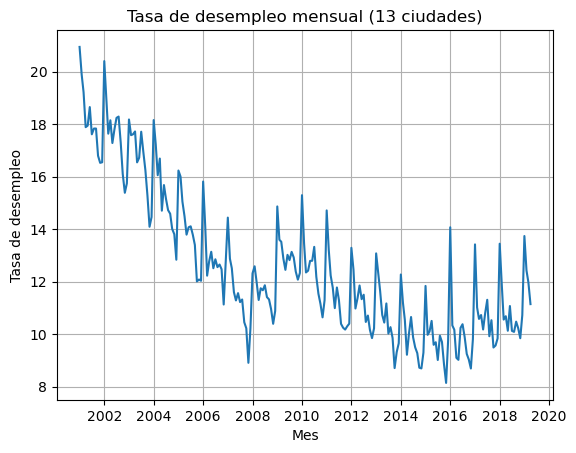

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["TD_13ciudades"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [ ]:
#Asi se extrae cada elemento de la descomposición de la serie.
td_componentes.seasonal

mes
2001-01-01    2.341068
2001-02-01    1.020286
2001-03-01    0.293373
2001-04-01    0.113895
2001-05-01   -0.217028
                ...   
2018-12-01   -0.856036
2019-01-01    2.341068
2019-02-01    1.020286
2019-03-01    0.293373
2019-04-01    0.113895
Name: seasonal, Length: 220, dtype: float64

### **Desestacionalizar**

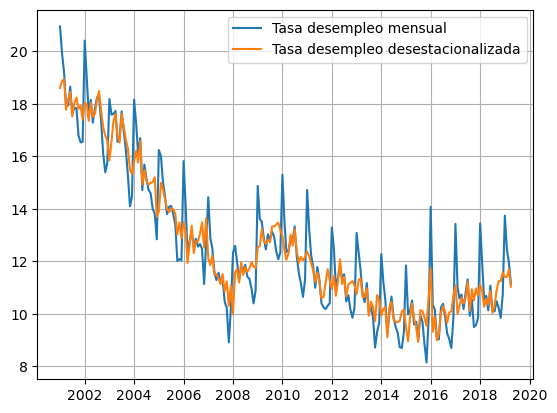

In [ ]:
td_desestacionalizada = data["TD_13ciudades"]-td_componentes.seasonal

plt.plot(data[["TD_13ciudades"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **4. Pronosticando metodos de suavización**

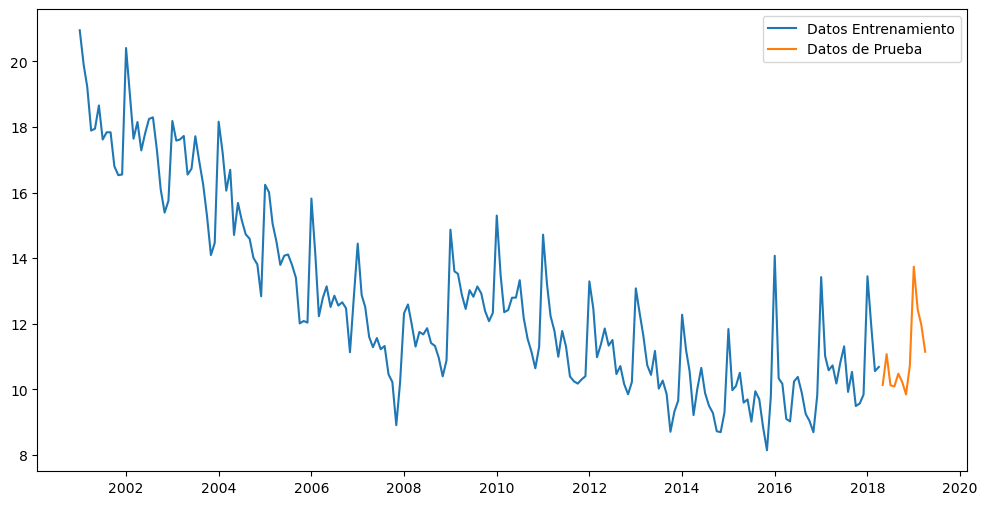

In [ ]:
train_len = 208
train_td = data[["TD_13ciudades"]][:train_len]
test_td = data[["TD_13ciudades"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

### **4.1 Promedio movil**

In [ ]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [ ]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [ ]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [ ]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [ ]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

1.1781369446057537 1.149344676431958 1.167290983502916 1.1536277219669278


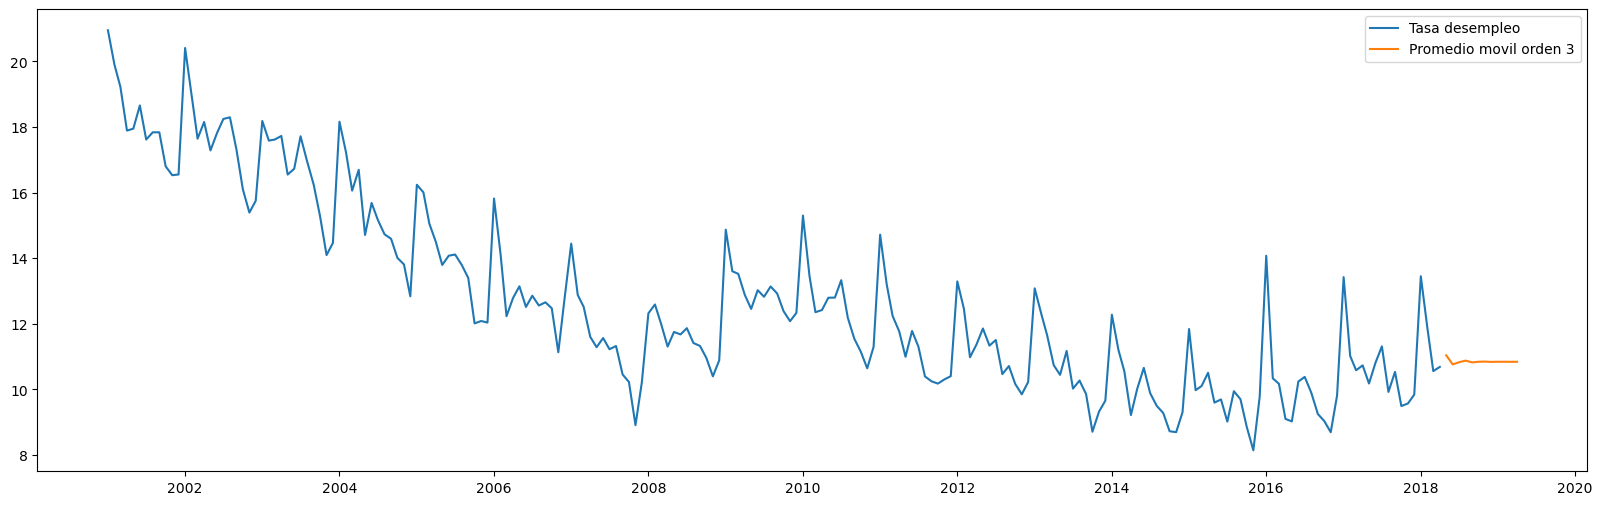

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [ ]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70018D+00    |proj g|=  8.99900D-01

At iterate    1    f=  1.62079D+00    |proj g|=  1.49058D-01

At iterate    2    f=  1.61317D+00    |proj g|=  1.24019D-01

At iterate    3    f=  1.59111D+00    |proj g|=  4.71286D-02

At iterate    4    f=  1.58529D+00    |proj g|=  2.12568D-02

At iterate    5    f=  1.58425D+00    |proj g|=  5.54465D-03

At iterate    6    f=  1.58416D+00    |proj g|=  3.26366D-03

At iterate    7    f=  1.58398D+00    |proj g|=  2.65237D-03

At iterate    8    f=  1.58353D+00    |proj g|=  6.89198D-03

At iterate    9    f=  1.58305D+00    |proj g|=  6.28746D-03

At iterate   10    f=  1.58299D+00    |proj g|=  9.10916D-04

At iterate   11    f=  1.58299D+00    |proj g|=  1.39622D-04

At iterate   12    f=  1.58299D+00    |proj g|=  2.08722D-06

           * * *

Tit   = 

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


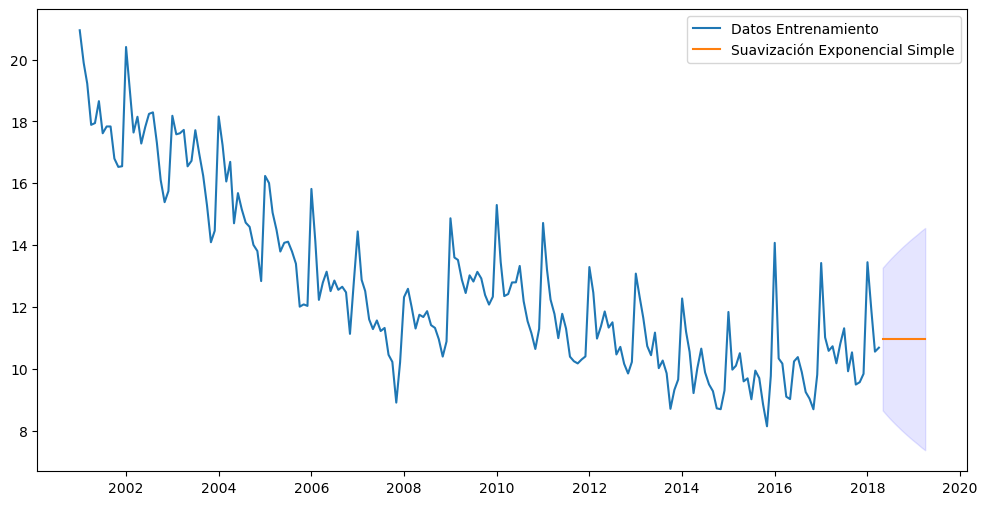

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
ets_result.alpha

0.359699522846234

In [ ]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

1.1244217727431585


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [ ]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68847D+00    |proj g|=  2.61327D+00

At iterate    1    f=  1.68628D+00    |proj g|=  2.50623D+00

At iterate    2    f=  1.66938D+00    |proj g|=  4.43755D-01

At iterate    3    f=  1.66810D+00    |proj g|=  3.37123D-01

At iterate    4    f=  1.66657D+00    |proj g|=  2.70083D-01

At iterate    5    f=  1.66386D+00    |proj g|=  2.84584D-01

At iterate    6    f=  1.66113D+00    |proj g|=  2.00751D-01

At iterate    7    f=  1.65297D+00    |proj g|=  2.80366D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f=  1.65234D+00    |proj g|=  2.37261D-01

At iterate    9    f=  1.65207D+00    |proj g|=  1.19597D-01

At iterate   10    f=  1.65188D+00    |proj g|=  5.84123D-01

At iterate   11    f=  1.65140D+00    |proj g|=  2.77642D-01

At iterate   12 

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


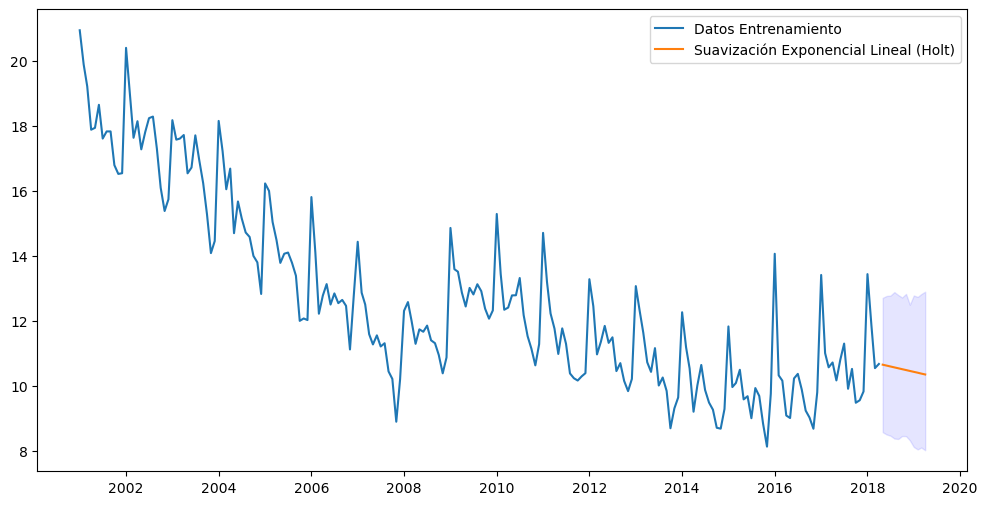

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.beta)

0.17153961352804556 1.7153961352804556e-05


In [ ]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

1.278004674468879


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [ ]:
# Build model
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08491D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.63679D+00    |proj g|=  3.74974D+00

At iterate    2    f=  1.37636D+00    |proj g|=  9.92830D-01

At iterate    3    f=  1.36903D+00    |proj g|=  2.05397D-01

At iterate    4    f=  1.35973D+00    |proj g|=  2.18863D-01

At iterate    5    f=  1.34912D+00    |proj g|=  2.34793D-01

At iterate    6    f=  1.29956D+00    |proj g|=  9.99800D-01

At iterate    7    f=  1.28088D+00    |proj g|=  1.42063D-01

At iterate    8    f=  1.27910D+00    |proj g|=  7.60377D-02

At iterate    9    f=  1.27649D+00    |proj g|=  4.81315D-02

At iterate   10    f=  1.27556D+00    |proj g|=  3.47521D-02

At iterate   11    f=  1.27409D+00    |proj g|=  3.39588D-02

At iterate   12    f=  1.27104D+00    |proj g|=  8.05018D-02

At iterate   13    f=  1.2

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


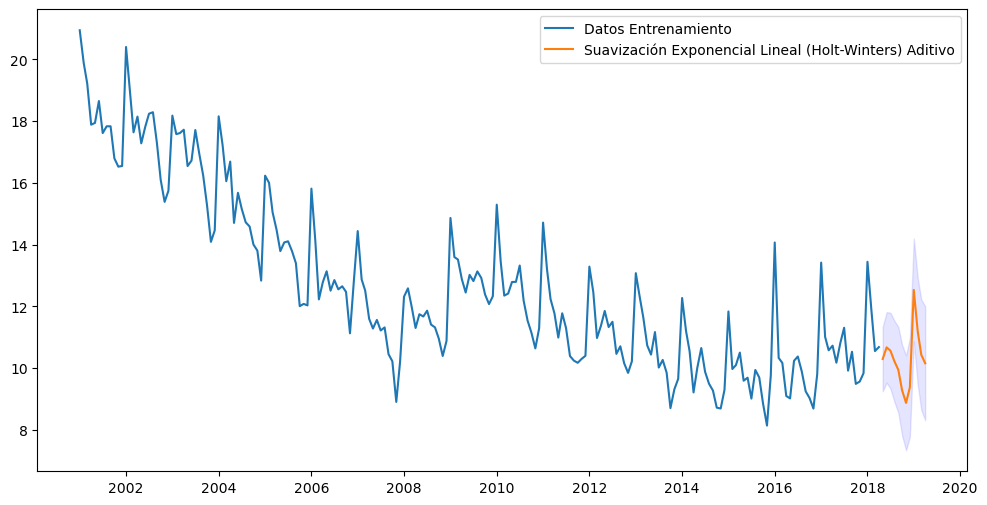

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.4385587423710869 4.385587423710869e-05 5.614412576289132e-05


In [ ]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

0.9425922289547983


In [ ]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04712D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.47758D+00    |proj g|=  1.11650D+00

At iterate    2    f=  1.06728D+00    |proj g|=  3.18501D-01

At iterate    3    f=  1.01780D+00    |proj g|=  1.51364D-01

At iterate    4    f=  9.72841D-01    |proj g|=  4.43520D-01

At iterate    5    f=  9.50933D-01    |proj g|=  1.53923D-01

At iterate    6    f=  9.43006D-01    |proj g|=  9.47001D-02

At iterate    7    f=  9.37750D-01    |proj g|=  8.52232D-02

At iterate    8    f=  9.33509D-01    |proj g|=  6.68821D-02

At iterate    9    f=  9.31377D-01    |proj g|=  8.50007D-02

At iterate   10    f=  9.28948D-01    |proj g|=  7.11160D-02

At iterate   11    f=  9.22280D-01    |proj g|=  9.21336D-02

At iterate   12    f=  9.20385D-01    |proj g|=  1.17555D-01

At iterate   13    f=  9.1

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


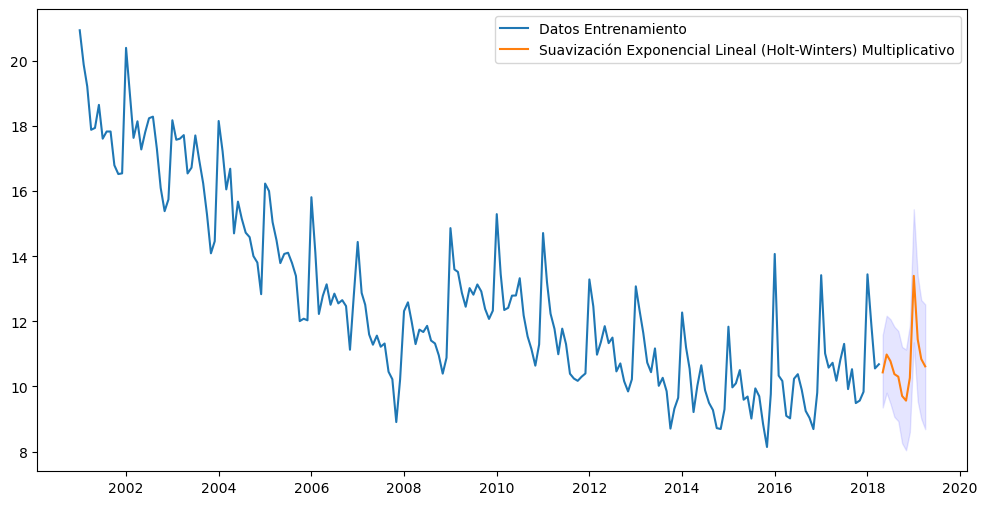

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.gamma)

0.4314984616512408 0.16097100968882755


In [ ]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

0.5659175258947138


### **Taller 1**

(220, 4)


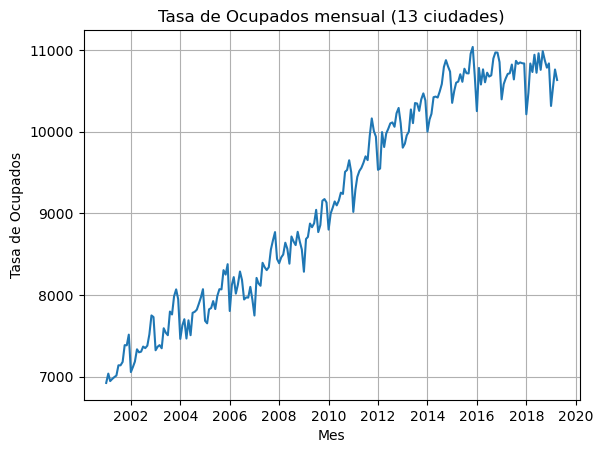

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de Ocupados mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

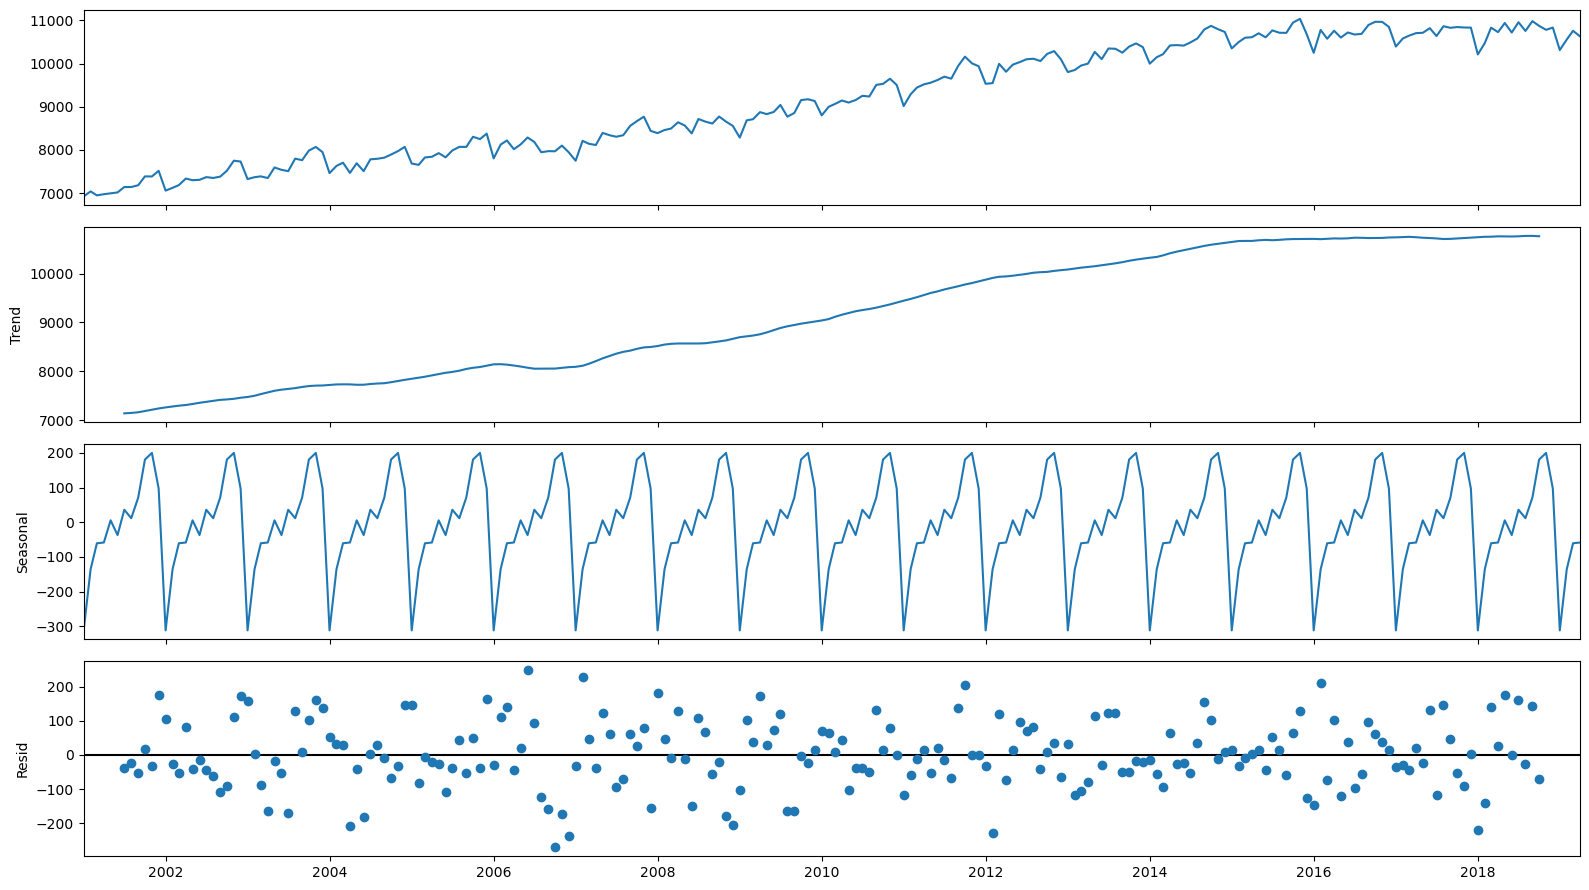

In [ ]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

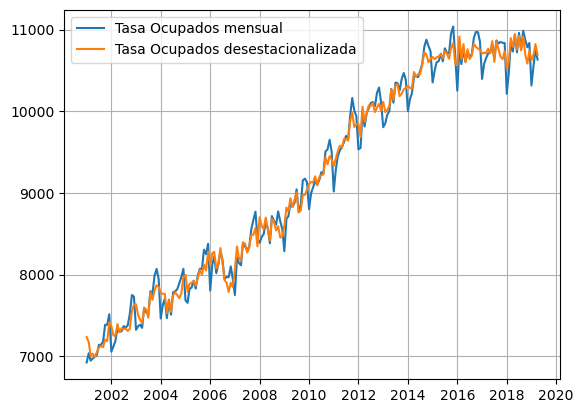

In [ ]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa Ocupados mensual")
plt.plot(td_desestacionalizada,label="Tasa Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()


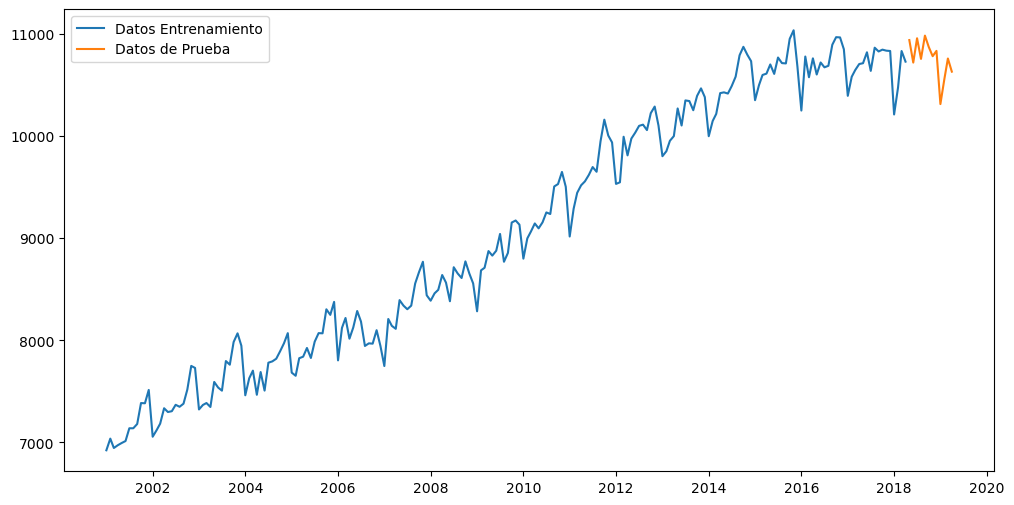

In [ ]:
train_len = 208
data_train = data[["Ocupados"]][:train_len]
data_test = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(data_test,label="Datos de Prueba")
plt.legend()
plt.show()

In [ ]:
#Promedio Movil
## Considerando el dato actual
ma_2= data_train.rolling(2,min_periods=2).mean()
ma_3= data_train.rolling(3,min_periods=2).mean()
ma_4= data_train.rolling(4,min_periods=2).mean()
ma_5= data_train.rolling(5,min_periods=2).mean()

In [ ]:
## Sin considerar el dato actual
ma_2= data_train.shift().rolling(2,min_periods=2).mean()
ma_3= data_train.shift().rolling(3,min_periods=2).mean()
ma_4= data_train.shift().rolling(4,min_periods=2).mean()
ma_5= data_train.shift().rolling(5,min_periods=2).mean()

In [ ]:
ma_2_f= fore_ma(data_train,2,12)
ma_3_f= fore_ma(data_train,3,12)
ma_4_f= fore_ma(data_train,4,12)
ma_5_f= fore_ma(data_train,5,12)

In [ ]:
rmse_ma_2 = np.sqrt(mean_squared_error(data_test,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(data_test,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(data_test,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(data_test,ma_5_f ))

In [ ]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749


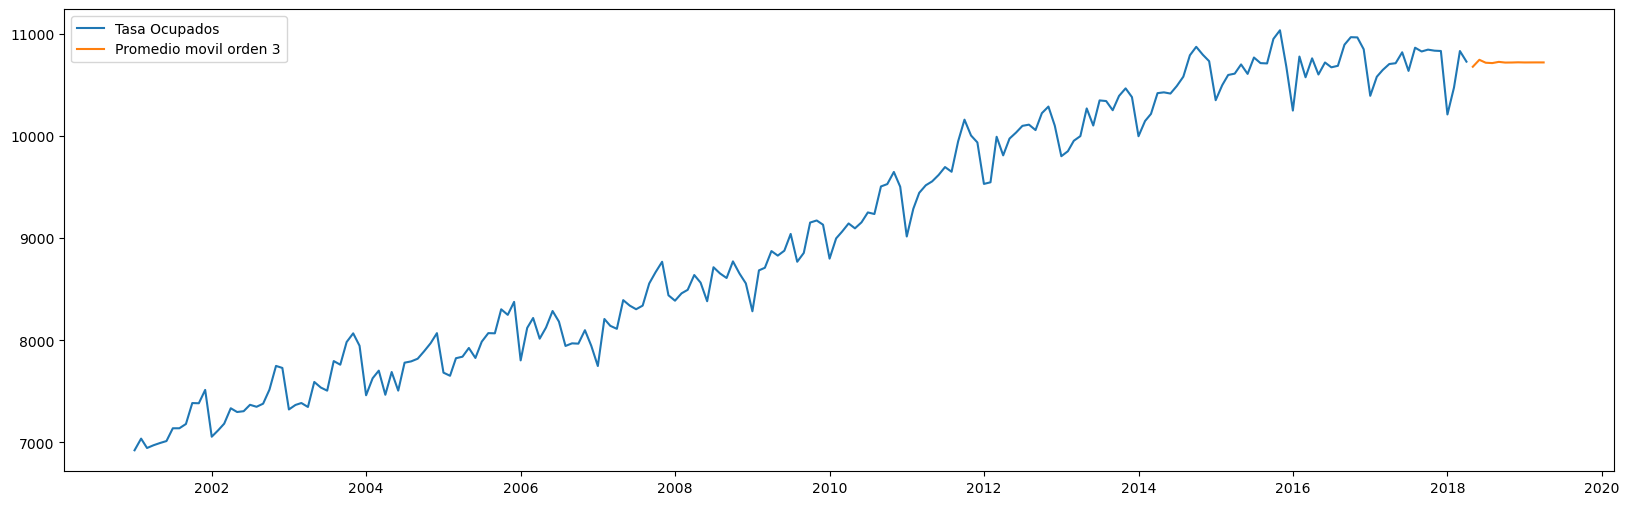

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.plot(data_train,label="Tasa Ocupados")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

In [ ]:
#Suavización Exponencial Simple
# Build model.
ets_model = ETSModel(endog=data_train["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01185D+00    |proj g|=  8.99900D-01

At iterate    1    f=  6.65682D+00    |proj g|=  1.95993D-01

At iterate    2    f=  6.63307D+00    |proj g|=  1.04807D-01

At iterate    3    f=  6.62290D+00    |proj g|=  5.64793D-03

At iterate    4    f=  6.62287D+00    |proj g|=  3.44702D-04

At iterate    5    f=  6.62287D+00    |proj g|=  1.69644D-05

At iterate    6    f=  6.62287D+00    |proj g|=  2.98428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 7     0     0   2.984D-05   6.623D+00
  F =   6.6228674754836883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


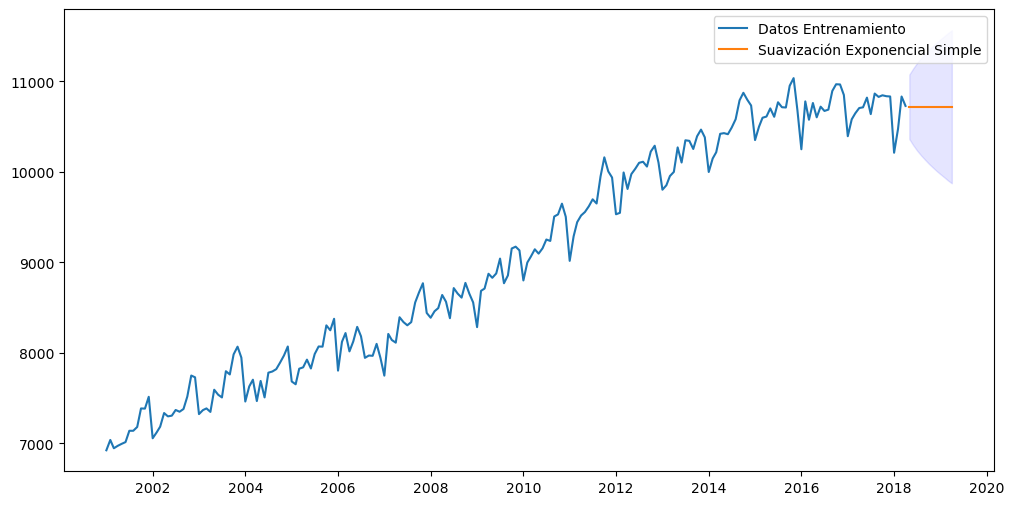

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
ets_result.alpha

0.648276208557338

In [ ]:
rmse = np.sqrt(mean_squared_error(data_test,point_forecast ))
print(rmse)

186.78644703989062


In [ ]:
# Suavización Exponencial Lineal (Holt) Build model.
ets_model = ETSModel(endog=data_train["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68362D+00    |proj g|=  1.26633D+01

At iterate    1    f=  6.66783D+00    |proj g|=  2.71056D-01

At iterate    2    f=  6.66777D+00    |proj g|=  3.50238D-01

At iterate    3    f=  6.66757D+00    |proj g|=  8.78870D-01

At iterate    4    f=  6.66673D+00    |proj g|=  2.06086D+00

At iterate    5    f=  6.66515D+00    |proj g|=  2.90385D+00

At iterate    6    f=  6.66175D+00    |proj g|=  3.11806D+00

At iterate    7    f=  6.62654D+00    |proj g|=  5.51325D+00

At iterate    8    f=  6.62147D+00    |proj g|=  6.47628D+00

At iterate    9    f=  6.61885D+00    |proj g|=  3.69566D+00

At iterate   10    f=  6.60490D+00    |proj g|=  8.73944D+00
  ys=-5.795E-03  -gs= 1.304E-02 BFGS update SKIPPED

At iterate   11    f=  6.60381D+00    |proj g|=  3.71625D+00

At iterate   12    f=  6.60197D+00  

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


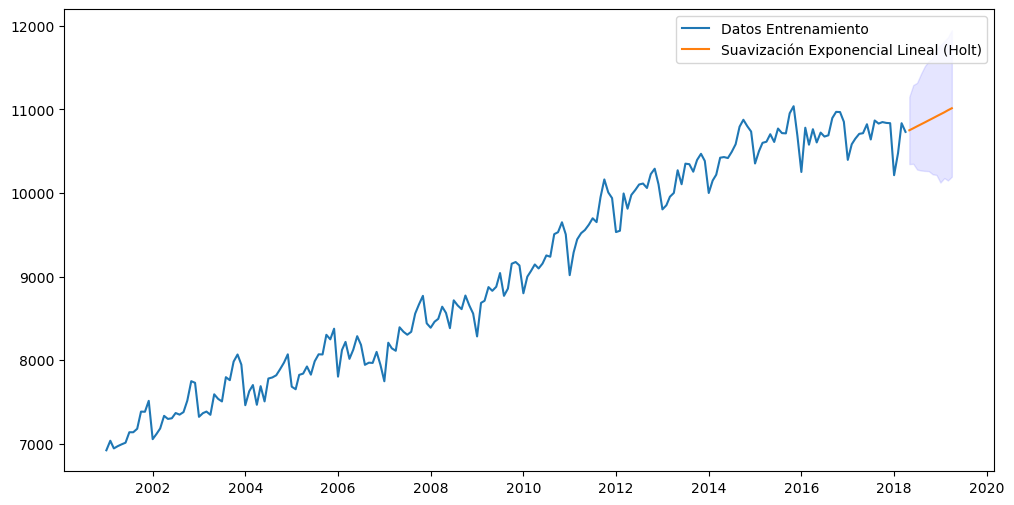

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.beta)

0.561935128100114 5.61935128100114e-05


In [ ]:
rmse_holt = np.sqrt(mean_squared_error(data_test,preds_holt['Point_forecast']))
print(rmse_holt)

268.07498368320023


In [ ]:
# Suavización Exponencial Lineal de Winters Build model
ets_model = ETSModel(endog=data_train["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10137D+00    |proj g|=  9.88789D-01

At iterate    1    f=  6.74656D+00    |proj g|=  9.99800D-01

At iterate    2    f=  6.49325D+00    |proj g|=  1.24737D-01

At iterate    3    f=  6.47289D+00    |proj g|=  8.90825D-02

At iterate    4    f=  6.46555D+00    |proj g|=  7.86740D-02

At iterate    5    f=  6.46361D+00    |proj g|=  9.14072D-02

At iterate    6    f=  6.45593D+00    |proj g|=  9.36264D-02

At iterate    7    f=  6.45419D+00    |proj g|=  5.22896D-02

At iterate    8    f=  6.45263D+00    |proj g|=  2.71267D-02

At iterate    9    f=  6.45196D+00    |proj g|=  1.17084D-02

At iterate   10    f=  6.45164D+00    |proj g|=  4.03828D-03

At iterate   11    f=  6.45162D+00    |proj g|=  3.71490D-03

At iterate   12    f=  6.45162D+00    |proj g|=  4.37339D-04

At iterate   13    f=  6.4

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


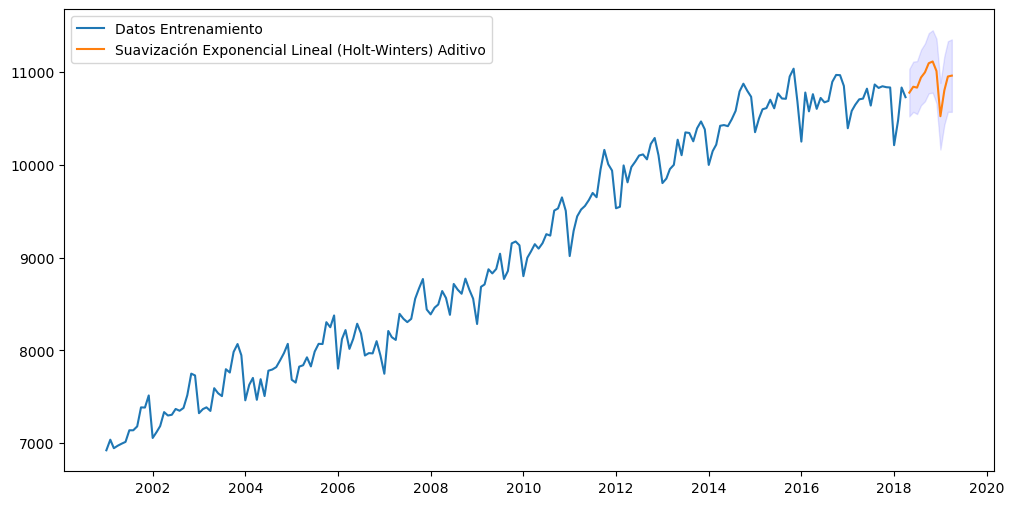

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.347885356294418 3.47885356294418e-05 0.32235832881196663


In [ ]:
rmse_hw_add = np.sqrt(mean_squared_error(data_test,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.5153599622515


In [ ]:
# Build model.
ets_model = ETSModel(endog=data_train["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30850D+00    |proj g|=  2.17821D+00

At iterate    1    f=  7.21102D+00    |proj g|=  2.70034D+00

At iterate    2    f=  6.58385D+00    |proj g|=  1.33786D+00

At iterate    3    f=  6.42184D+00    |proj g|=  9.56503D-01

At iterate    4    f=  6.34599D+00    |proj g|=  7.14024D-01

At iterate    5    f=  6.29586D+00    |proj g|=  4.33919D-01

At iterate    6    f=  6.26889D+00    |proj g|=  3.42415D-01

At iterate    7    f=  6.25333D+00    |proj g|=  4.45771D-01

At iterate    8    f=  6.24399D+00    |proj g|=  3.69049D-01

At iterate    9    f=  6.23892D+00    |proj g|=  1.52270D-01

At iterate   10    f=  6.23491D+00    |proj g|=  1.69297D-01

At iterate   11    f=  6.23418D+00    |proj g|=  1.69416D-01

At iterate   12    f=  6.23343D+00    |proj g|=  1.10872D-01

At iterate   13    f=  6.2

/Users/Jarimso/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


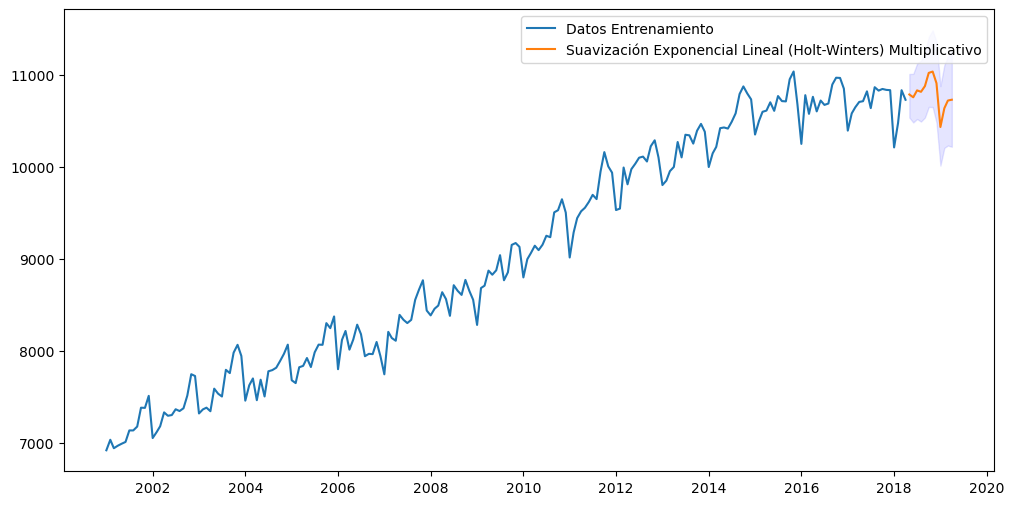

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
print(ets_result.alpha,ets_result.gamma)

0.6067556827108754 3.932443172891246e-05


In [ ]:
rmse_hw_mul = np.sqrt(mean_squared_error(data_test,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

122.36063923525518


In [ ]:
fecha_inicio_pronostico = data['Ocupados'].index[-1] + pd.DateOffset(months=1)

# Generar pronóstico para los siguientes 6 meses
horizonte_pronostico = 6
ci = ets_result.get_prediction(start=fecha_inicio_pronostico, end=fecha_inicio_pronostico + pd.DateOffset(months=horizonte_pronostico - 1))
pronostico_siguientes_meses = ci.predicted_mean

# Crear un índice de fechas para el pronóstico
fechas_pronostico = pd.date_range(start=fecha_inicio_pronostico, periods=horizonte_pronostico, freq='MS')

# Crear un DataFrame con las fechas y el pronóstico
pronostico_df = pd.DataFrame({'Point_forecast': pronostico_siguientes_meses}, index=fechas_pronostico)

# Imprimir el pronóstico
print("Pronóstico para los siguientes 6 meses:")
print(pronostico_df)

Pronóstico para los siguientes 6 meses:
            Point_forecast
2019-05-01    10787.445340
2019-06-01    10757.065624
2019-07-01    10832.086406
2019-08-01    10816.529607
2019-09-01    10878.550581
2019-10-01    11021.781009


## **Taller 2**

In [ ]:
data


,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403


**Preparación de los datos**

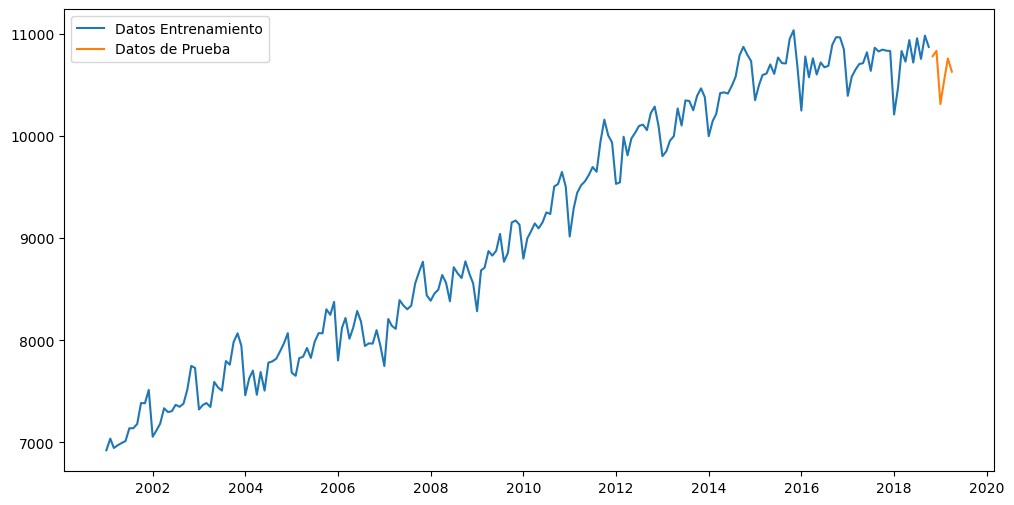

In [ ]:
train_len = 214
data_train = data[["Ocupados"]][:train_len]
data_test = data[["Ocupados"]][train_len:]


fig = plt.figure(figsize=(12, 6))
plt.plot(data_train,label="Datos Entrenamiento")
plt.plot(data_test,label="Datos de Prueba")
plt.legend()
plt.show()

**Dumificar**

In [ ]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
train_dummy=month_dummies[:train_len]
test_dummy=month_dummies[train_len:]

,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2018-11-01,0,0,0,0,0,0,0,0,0,1,0
2018-12-01,0,0,0,0,0,0,0,0,0,0,1
2019-01-01,0,0,0,0,0,0,0,0,0,0,0
2019-02-01,1,0,0,0,0,0,0,0,0,0,0
2019-03-01,0,1,0,0,0,0,0,0,0,0,0
2019-04-01,0,0,1,0,0,0,0,0,0,0,0


### **Modelos**

**Tendencia Lineal**

In [ ]:
y = data_train["Ocupados"]
X = sm.add_constant(train_dummy)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.3250
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.980
Time:                        16:23:15   Log-Likelihood:                -1833.0
No. Observations:                 214   AIC:                             3690.
Df Residuals:                     202   BIC:                             3730.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    308.067     28.320      0.0

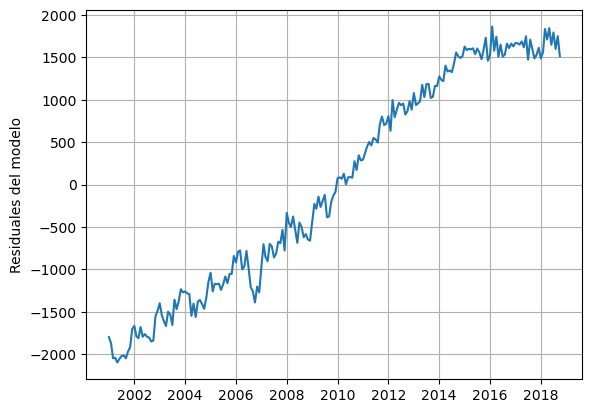

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

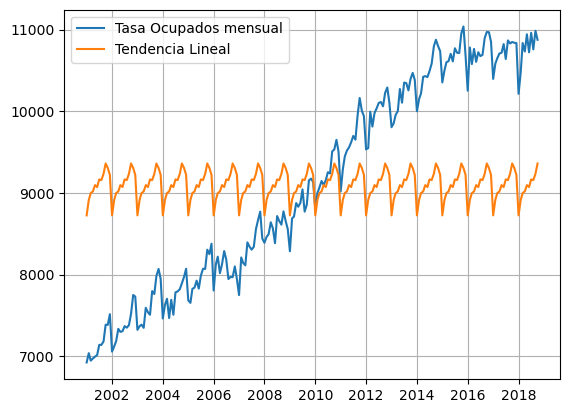

In [ ]:
plt.plot(y,label="Tasa Ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Ajustar el modelo a los datos de entrenamiento
y_train = data_train["Ocupados"]
X_train = sm.add_constant(train_dummy)
model = sm.OLS(y_train, X_train)
result = model.fit()

# Realizar predicciones en los datos de prueba
y_test = data_test["Ocupados"]
X_test = sm.add_constant(test_dummy)
y_pred = result.predict(X_test)

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 1619.6142268040358


In [ ]:
range_dates = pd.date_range(data_train.index[-1]+ relativedelta(months=1), periods=6,freq='MS')
X_for= sm.add_constant(test_dummy)

print(X_for)

            const  2  3  4  5  6  7  8  9  10  11  12
mes                                                  
2018-11-01    1.0  0  0  0  0  0  0  0  0   0   1   0
2018-12-01    1.0  0  0  0  0  0  0  0  0   0   0   1
2019-01-01    1.0  0  0  0  0  0  0  0  0   0   0   0
2019-02-01    1.0  1  0  0  0  0  0  0  0   0   0   0
2019-03-01    1.0  0  1  0  0  0  0  0  0   0   0   0
2019-04-01    1.0  0  0  1  0  0  0  0  0   0   0   0


In [ ]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)

print(preds)

            Point_forecast     lower_95      upper_95
2018-11-01     9386.702222  6722.140249  12051.264196
2018-12-01     9310.332667  6645.770693  11974.894640
2019-01-01     8808.217632  6147.348746  11469.086517
2019-02-01     9001.037684  6340.168799  11661.906569
2019-03-01     9090.037158  6429.168273  11750.906043
2019-04-01     9102.647316  6441.778431  11763.516201


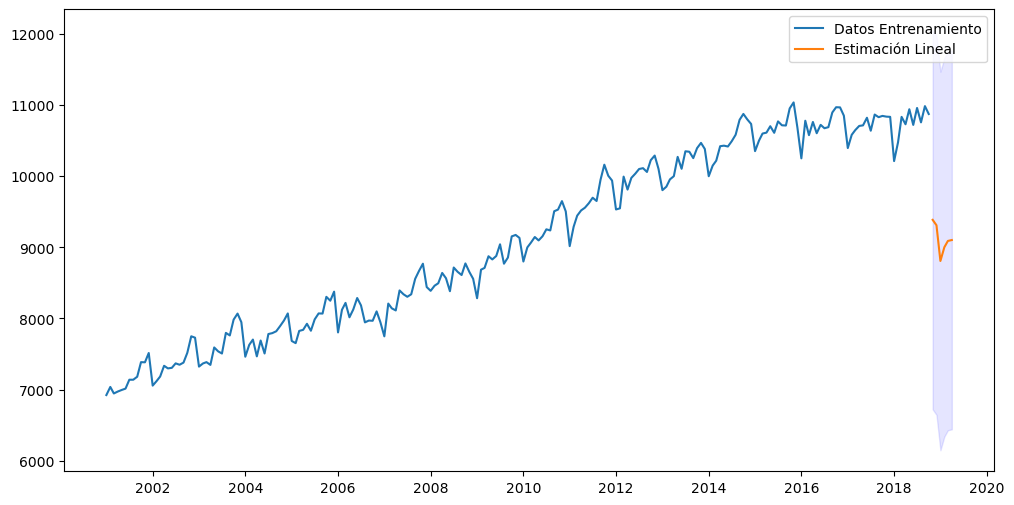

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Lineal")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
# Tomar y_test del conjunto de prueba
y_test = data_test["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_lineal = r2_score(y_test, y_prd)
rmse_lineal = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R**2 : {r2_lineal}")
print(f"RMSE : {rmse_lineal}")

Coef R**2 : -74.8950403860965
RMSE : 1532.9303848386514


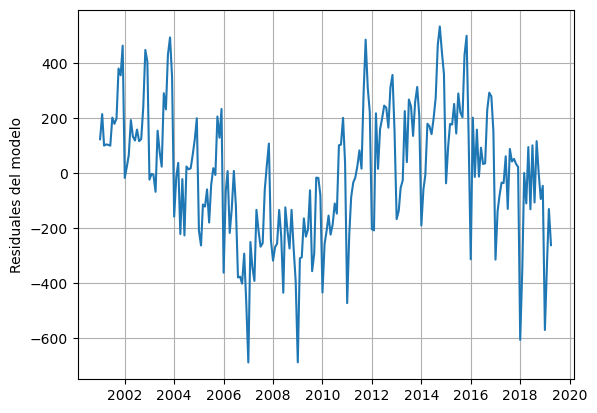

**Tendencia + Estacionalidad**

In [ ]:
y = data_train["Ocupados"]
x = np.linspace(1,data_train.shape[0],data_train.shape[0])
data_train["x"] = x
data_train["x2"] = x**2
data_train["x3"] = x**3
data_train["x4"] = x**4
data_train["x5"] = x**5
X = sm.add_constant(pd.concat([data_train[["x","x2","x3","x4","x5"]],train_dummy],axis=1))
pol = sm.OLS(y,X)
pol_5 = pol.fit()
print(pol_5.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1447.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):          1.19e-194
Time:                        16:39:37   Log-Likelihood:                -1324.0
No. Observations:                 214   AIC:                             2682.
Df Residuals:                     197   BIC:                             2739.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6588.6414     58.135    113.334      0.0

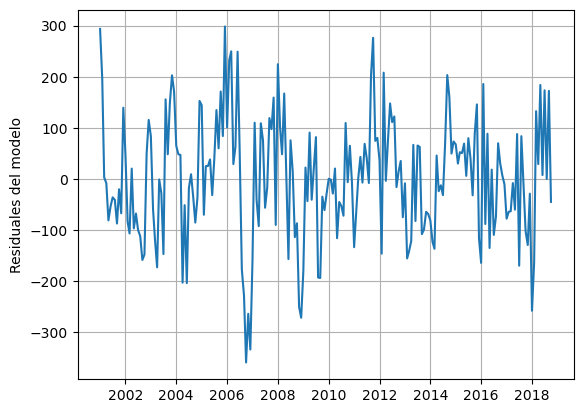

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_5.resid)
plt.grid()

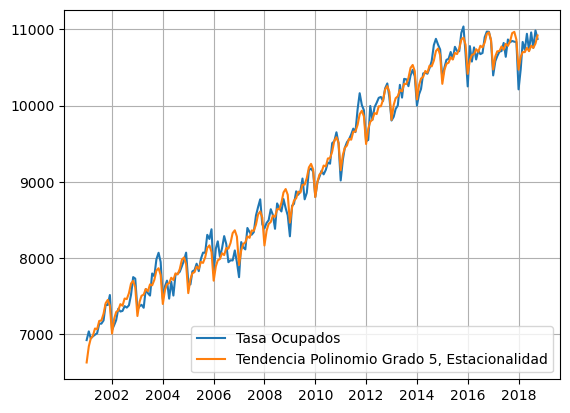

In [ ]:
plt.plot(y,label="Tasa Ocupados")
plt.plot(pol_5.fittedvalues,label="Tendencia Polinomio Grado 5, Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [ ]:
h=6
x_for= np.linspace((data_train.shape[0]+1),(data_train.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3, x_for**4,x_for**5),axis=1),columns=["x","x2","x3","x4","x5"] ) # Dataframe de los x

test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for

,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
0,1.0,215.0,46225.0,9938375.0,2.136751e+09,4.594014e+11,0,0,0,0,0,0,0,0,0,1,0
1,1.0,216.0,46656.0,10077696.0,2.176782e+09,4.701850e+11,0,0,0,0,0,0,0,0,0,0,1
2,1.0,217.0,47089.0,10218313.0,2.217374e+09,4.811701e+11,0,0,0,0,0,0,0,0,0,0,0
3,1.0,218.0,47524.0,10360232.0,2.258531e+09,4.923597e+11,1,0,0,0,0,0,0,0,0,0,0
4,1.0,219.0,47961.0,10503459.0,2.300258e+09,5.037564e+11,0,1,0,0,0,0,0,0,0,0,0
5,1.0,220.0,48400.0,10648000.0,2.342560e+09,5.153632e+11,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
dt = pol_5.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2019-05-01    10934.198252  10664.272414  11204.124090
2019-06-01    10829.067438  10555.714341  11102.420535
2019-07-01    10435.200323  10157.781608  10712.619037
2019-08-01    10603.226909  10321.375191  10885.078626
2019-09-01    10664.267935  10377.406896  10951.128975
2019-10-01    10663.468116  10370.976494  10955.959738


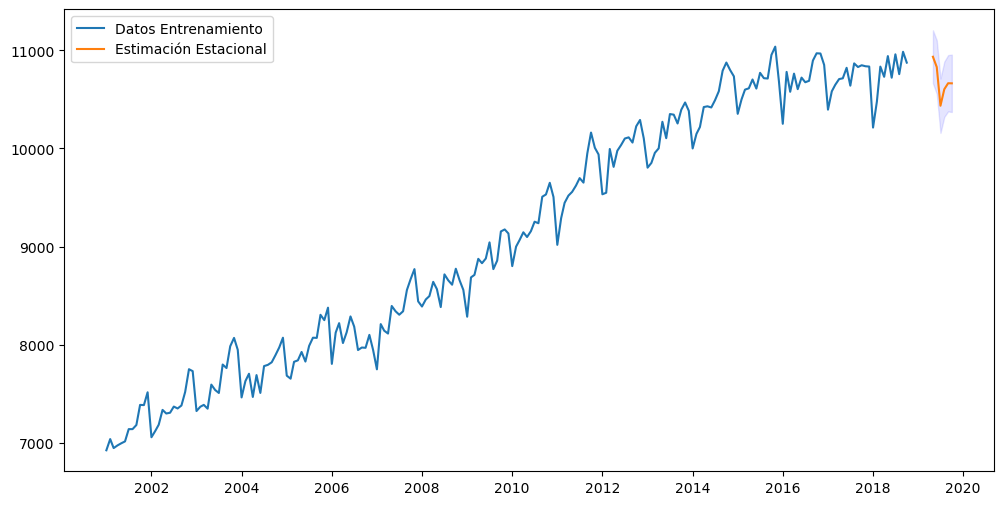

In [ ]:

#Grafico de predicciones con modelo tendencia grado 5 + estacionalidad
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:

y_test = data_test["Ocupados"]
y_test.index = range(len(y_test))

r2_g5 = r2_score(y_test, y_prd)
rmse_g5  = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R5 : {r2_g5}")
print(f"RMSE : {rmse_g5}")

Coef R5 : 0.7322029581466069
RMSE : 91.05810795858785


## **Supuestos**

In [ ]:
signo = pol_5.resid>0

In [ ]:
runstest_1samp(signo, correction=False)

(-3.8361549673925706, 0.00012497556616534246)

El segundo valor corresponde al p-valor=0.00012, por lo tanto considerando un $α$=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie y1 parece no comportarse como un ruido blanco, **Se presenta autocorrelación**.

In [ ]:
sm.stats.acorr_ljungbox(pol_5.resid, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,35.442594,2.626793e-09,34.950336,3.382231e-09


Con el resultado anterior rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión Es probar por lo menos los primeros 20 rezagos.

In [ ]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.Ocupados, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,213.848488,1.987331e-48,210.958644,8.486316e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,421.882574,2.451111e-92,415.244368,6.773783e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,625.378784,3.172685e-135,614.157330,8.594402e-133,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,825.355742,2.471383e-177,808.729505,9.873368e-174,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1021.698974,1.204937e-218,998.881735,1.049496e-213,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1213.666388,5.275121e-259,1183.931404,1.437450e-252,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1402.321425,1.214195e-298,1364.938264,1.488143e-290,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1586.436188,0.000000e+00,1540.759569,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1767.316037,0.000000e+00,1712.676902,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1945.503650,0.000000e+00,1881.232753,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


El resultado del test de Ljung-Box muestra que se rechaza la hipótesis nula de no autocorrelación para todos los lags considerados (1 al 20). Esto se evidencia por los valores bajos de p (p-value) en las columnas lb_pvalue y bp_pvalue.

En el caso del test de Ljung-Box (lb_stat), los estadísticos son significativamente altos, y en el caso del test de Box-Pierce (bp_stat), también son altos, lo que indica la presencia de autocorrelación en los residuos.

En términos simples, esto sugiere que hay evidencia de autocorrelación en los residuos del modelo, lo cual es una violación de la suposición de independencia de los residuos en el análisis de regresión.

## **Homoscedasticidad y Heteroscedasticidad**

In [ ]:
sm.stats.acorr_ljungbox((data.Ocupados-data.Ocupados.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,183.983988,6.540417e-42,181.497718,2.282523e-41
2,349.643863,1.190693e-76,344.172730,1.835867e-75
3,500.892842,3.056176e-108,492.015200,2.564874e-106
4,642.578833,9.419447e-138,629.871841,5.304772e-135
5,778.288564,5.754246e-166,761.302436,2.717324e-162
6,904.994860,3.125971e-192,883.442739,1.425870e-187
7,1028.510888,8.321118e-218,1001.951361,4.562051e-212
8,1143.427839,1.597591e-241,1111.691872,1.143498e-234
9,1257.321649,5.096909e-265,1219.942296,6.002466e-257
10,1372.708674,7.737770e-289,1329.092184,2.012827e-279


Si el valor p obtenido de una prueba de homocedasticidad es menor que el nivel de significancia (generalmente establecido en 0.05), entonces se rechaza la hipótesis nula de homocedasticidad y se concluye que los errores no son homocedásticos, lo que implica la presencia de heteroscedasticidad.

## **Normalidad**

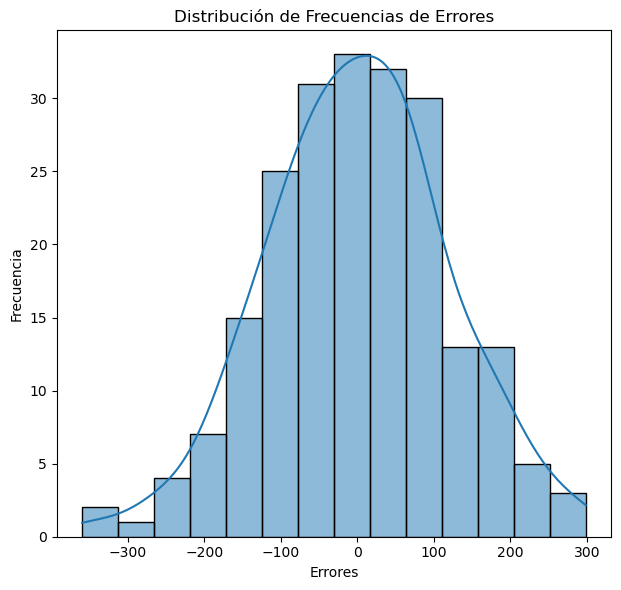

In [ ]:
import seaborn as sns
# Distribución de Frecuencias
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(pol_5.resid, kde=True)
plt.xlabel('Errores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencias de Errores')

plt.tight_layout()
plt.show()

In [ ]:
stats.shapiro(pol_5.resid)


ShapiroResult(statistic=0.9966813921928406, pvalue=0.9314735531806946)

In [ ]:
stats.jarque_bera(pol_5.resid)


SignificanceResult(statistic=0.33958823112050307, pvalue=0.8438385319365133)

Para ambas pruebas, no se puede rechazar la hipótesis de que los datos provienen de una distribución normal. Así, parece ser que la serie y1 proviene de un proceso ruido blanco gaussiano.

### Conclusión

Se ha realizado un análisis exhaustivo de regresión polinómica de quinto grado. El modelo ajustado muestra un buen ajuste, con un alto R-cuadrado ajustado. Sin embargo, al analizar los residuos, se encontró evidencia de autocorrelación hasta el lag 20 y heteroscedasticidad.

Las predicciones del modelo en el conjunto de prueba indican un rendimiento razonable, con un R-cuadrado de aproximadamente 0.732 y un RMSE de alrededor de 91.06.